In [54]:
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import numpy as np
from PIL import Image         
import cv2                 
import matplotlib.pyplot as plt
from os import getcwd
import csv

In [55]:
load_side_camera_images_flag = True
record_img_path = './record/IMG/'

X_data = []
y_data = []

correction = .175

def load_images():    
    with open('./record/driving_log.csv', 'r') as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            angle = float(row[3])
            center_file_name = row[0].strip().split("/")[-1]
            img_path = record_img_path + center_file_name
            X_data.append(img_path)
            y_data.append(angle)
            
            if load_side_camera_images_flag:
                left_file_name = row[1].strip().split("/")[-1]
                img_path_left = record_img_path + left_file_name
                X_data.append(img_path_left)
                y_data.append(angle + correction) 
                
                right_file_name = row[2].strip().split("/")[-1]
                img_path_right = record_img_path + right_file_name
                X_data.append(img_path_right)
                y_data.append(angle - correction)    
                
load_images() 


X_data = np.array(X_data)
y_data = np.array(y_data)
print('Data Samples shape:', X_data.shape, y_data.shape)

Data Samples shape: (210,) (210,)


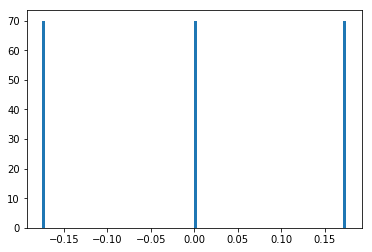

[(0.0, 70), (0.17499999999999999, 70), (-0.17499999999999999, 70)]


In [56]:
#Data distribution
#Large number of data points for 3 valuse, and smaller number for rest of data points
from collections import Counter

plt.hist(y_data, 100)
plt.show()

counts = Counter(y_data)
print (counts.most_common(3) )

In [70]:
def flip(img,angle):
    return cv2.flip(img,1),-angle

def shift(img,angle):
    # this will shift image horizontally and vertically and add a small value--> same in Project2
    rows,cols,ch = img.shape
    range_tr = 100
    dx = range_tr * np.random.uniform() - range_tr/2
    dy = 40 * np.random.uniform()-40/2
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    img = cv2.warpAffine(img, M, (cols, rows))
    angle += dx/range_tr*2*.2
    return img, angle

def brightness(img, angle):
    if np.random.uniform()>0.5:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        deltaBright = .5 + np.random.uniform() * 0.5
        hsv[:, :, 2] = np.around(hsv[:, :, 2] * deltaBright)
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img, angle

def augment(img, angle):
    img, angle = flip(img, angle)
    img, angle = shift(img, angle)    
    img, angle = brightness(img, angle)                    
    return img, angle


./record/IMG/left_2018_06_02_12_50_06_665.jpg
(160, 320, 3)


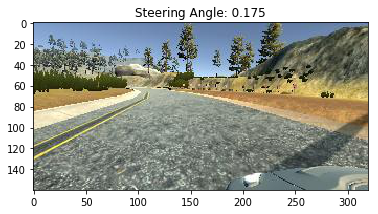

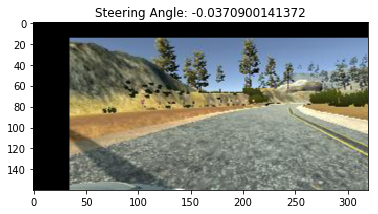

In [58]:
# Example of Images
index = 100

# Original Image
print(X_data[index])
img = cv2.imread(X_data[index])
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Steering Angle: '+ str(y_data[index]))
plt.savefig('./original_image.png')
plt.show()

# Augment Image
new_img,new_angle = augment(img,y_data[index])
plt.imshow(new_img)
plt.title('Steering Angle: '+ str(new_angle))
plt.savefig('./image_augment.png')
plt.show()

In [71]:
def generate_training_data(image_paths, angles, batch_size=128, validation_flag=False):
    image_paths, angles = shuffle(image_paths, angles)
    while True:       
        for offset in range(0,len(angles),batch_size):
            batch_samples_paths = image_paths[offset:offset+batch_size]
            batch_samples_angles = angles[offset:offset+batch_size]
            images_gen,angles_gen = ([],[])
            for i in range(len(batch_samples_paths)):
                img = cv2.imread(batch_samples_paths[i])
                angle = batch_samples_angles[i]
#                 img = augment(img, angle)
#                 if not validation_flag:
#                     img, angle = augment(img, angle)
                images_gen.append(img)
                angles_gen.append(angle)
            yield (np.array(images_gen), np.array(angles_gen))
            image_paths, angles = shuffle(image_paths, angles)

# use batch Normalization and L2 Regularizer to prevent overfitting, instead of dropout.
def train_model(image_paths, angles):
    image_paths_train, image_paths_valid, \
        angles_train, angles_valid = train_test_split(image_paths, angles, test_size=0.2, random_state=42)
    
    model = Sequential()

    # Normalize
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))

    # Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))#, W_regularizer=l2(0.001)))
    model.add(ELU())
#     model.add(BatchNormalization(axis=-1))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))#, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))#, W_regularizer=l2(0.001)))
    model.add(ELU())

    #model.add(Dropout(0.50))
    
    # Add two 3x3 convolution layers (output depth 64, and 64)
    model.add(Convolution2D(64, 3, 3, border_mode='valid'))#, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode='valid'))#, W_regularizer=l2(0.001)))
    model.add(ELU())

    # Add a flatten layer
    model.add(Flatten())

    # Add three fully connected layers (depth 100, 50, 10), tanh activation (and dropouts)
    model.add(Dense(100))#, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(50))#, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(10))#, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))

    # Add a fully connected output layer
    model.add(Dense(1))

    # Compile and train the model
    model.compile(optimizer=Adam(lr=1e-4), loss='mse')

    print(model.summary())
    # initialize generators
    train_gen = generate_training_data(image_paths_train, angles_train, validation_flag=False, batch_size=120)
    val_gen = generate_training_data(image_paths_valid, angles_valid, validation_flag=True, batch_size=120)

    checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=2, save_best_only=True)
    history = model.fit_generator(train_gen, validation_data=val_gen, 
                                  nb_val_samples=image_paths_train.shape[0], 
                                  samples_per_epoch=image_paths_train.shape[0],
                                  nb_epoch=20, verbose=2, callbacks=[checkpoint])

    # Save model data
    model.save('model.h5')
    print('Model Saved..')
    return history
    
history = train_model(X_data, y_data)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_21 (Lambda)               (None, 160, 320, 3)   0           lambda_input_21[0][0]            
____________________________________________________________________________________________________
cropping2d_20 (Cropping2D)       (None, 65, 320, 3)    0           lambda_21[0][0]                  
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 31, 158, 24)   1824        cropping2d_20[0][0]              
____________________________________________________________________________________________________
elu_153 (ELU)                    (None, 31, 158, 24)   0           convolution2d_96[0][0]           
___________________________________________________________________________________________

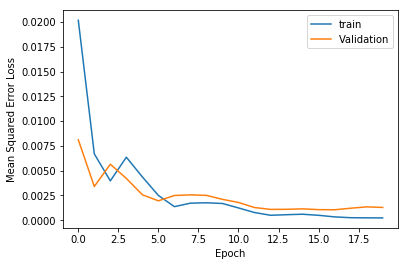

In [72]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()
fig.savefig('./train_val_acc.png')